# Imports

In [1]:
!python --version

!pip install networkx matplotlib --quiet

Python 3.11.12


In [26]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import csv
import json

# Graphs

This defines a basic graph data structure, which can be initialized from an adjacency matrix or edge set.

In [27]:
class Graph:
    def __init__(self, data, from_adjacency_matrix=False, vertices=None):
        self.adj = {}
        if from_adjacency_matrix:
            self._init_from_adj_matrix(data)
        else:
            self._init_from_edge_list(data)

        if vertices is not None:
            for v in vertices:
                if v not in self.adj:
                    self.adj[v] = set()

    def _init_from_adj_matrix(self, matrix):
        n = len(matrix)
        for i in range(n):
            self.adj[i] = set()
            for j in range(n):
                if matrix[i][j]:
                    self.adj[i].add(j)

    def _init_from_edge_list(self, edge_list):
        for u, v in edge_list:
            if u not in self.adj:
                self.adj[u] = set()
            if v not in self.adj:
                self.adj[v] = set()
            self.adj[u].add(v)
            self.adj[v].add(u)

    def __repr__(self):
        return f"graph with {len(self.V())} vertices and {len(self.E())} edges"

    def V(self):
        return set(self.adj.keys())

    def E(self):
        seen = set()
        edges = set()
        for u in self.adj:
            for v in self.adj[u]:
                if (v, u) not in seen:
                    edges.add((u, v))
                    seen.add((u, v))
        return edges

# helper functions for standard graph notation
def V(G): return G.V()
def E(G): return G.E()

In [28]:
G1 = Graph([[0,1,0],[1,0,1],[0,1,0]], from_adjacency_matrix=True)
G2 = Graph([(0,1),(1,2)])

print(V(G1))  # {0, 1, 2}
print(E(G1))  # {(0,1), (1,2)}

print(V(G2))  # {0, 1, 2}
print(E(G2))  # {(0,1), (1,2)}

{0, 1, 2}
{(0, 1), (1, 2)}
{0, 1, 2}
{(0, 1), (1, 2)}


# Erdős–Rényi Random Graphs

Generates a random graph $G$ on $n$ vertices as follows: for each pair of vertices $u,v \in \binom{[n]}2$, include $uv \in E(G)$ independently with probability $p$.

In [29]:
def random_graph(n, p, seed=None):
    if seed is not None:
        random.seed(seed)

    edges = []
    for i in range(n):
        for j in range(i + 1, n):
            if random.random() < p:
                edges.append((i, j))

    return Graph(edges, vertices=list(range(n)))

The following function uses the networkx library to display graphs.

In [30]:
def draw_graph(G):
    nxG = nx.Graph()
    nxG.add_nodes_from(V(G))
    nxG.add_edges_from(E(G))

    pos = nx.spring_layout(nxG)
    nx.draw(nxG, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=600, font_size=12)

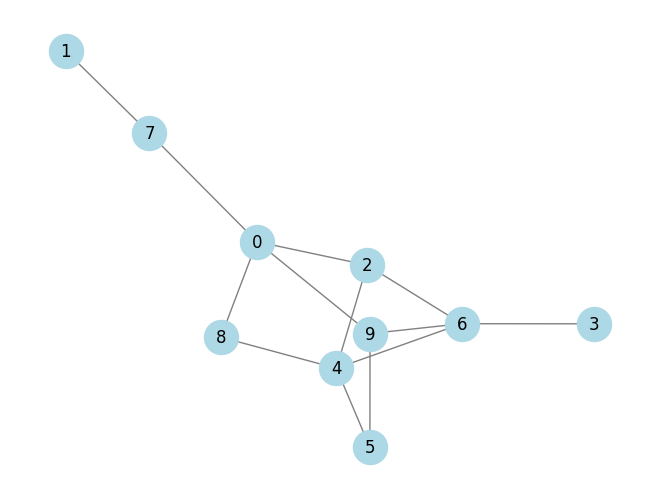

In [31]:
G = random_graph(10, 0.3)
draw_graph(G)

# Graph Parameters

Here we code functions which calculate the true tested parameters of a graph. The parameters of interest are:


*   maximum degree (int)
*   size of largest clique subgraph (int)
*   is the graph connected (bool)
*   is the graph bipartite (bool)
*   does the graph have a Hamiltonian cycle (bool)

Some of these parameters are NP-hard to compute, but for our use case the graphs are small enough that brute force is still quick.

In [32]:
def max_degree(G):
    return max(len(neighbors) for neighbors in G.adj.values())

In [33]:
# simply run DFS at any starting point and see if we visit the whole graph
def is_connected(G):
    visited = set()
    def dfs(v):
        visited.add(v)
        for u in G.adj[v]:
            if u not in visited:
                dfs(u)
    start = next(iter(G.V()))
    dfs(start)
    return len(visited) == len(G.V())

In [34]:
# loop over each connected component checking if each is 2-colorable
def is_bipartite(G):
    color = {}
    for start in G.V():
        if start in color:
            continue
        queue = [start]
        color[start] = 0
        while queue:
            v = queue.pop()
            for u in G.adj[v]:
                if u not in color:
                    color[u] = 1 - color[v]
                    queue.append(u)
                elif color[u] == color[v]:
                    return False
    return True

In [35]:
# naive backtracking implementation, takes a while for larger graphs
def has_hamiltonian_cycle(G):
    n = len(G.V())
    vertices = list(G.V())

    def backtrack(path):
        if len(path) == n:
            return path[0] in G.adj[path[-1]]  # return to start
        for v in G.adj[path[-1]]:
            if v not in path:
                if backtrack(path + [v]):
                    return True
        return False

    for start in vertices:
        if backtrack([start]):
            return True
    return False

In [36]:
def largest_clique_size(G):
    V = list(G.V())
    max_size = 0
    for r in range(1, len(V)+1):
        for subset in combinations(V, r):
            if all(u in G.adj[v] for i, u in enumerate(subset) for v in subset[i+1:]):
                max_size = r
    return max_size

In [37]:
# this just aggregates results for each graph in one place
def evaluate_graph(G):
    return {
        "max_degree": max_degree(G),
        "is_connected": is_connected(G),
        "is_bipartite": is_bipartite(G),
        "has_hamiltonian_cycle": has_hamiltonian_cycle(G),
        "largest_clique_size": largest_clique_size(G)
    }

{'max_degree': 6, 'is_connected': True, 'is_bipartite': False, 'has_hamiltonian_cycle': True, 'largest_clique_size': 4}


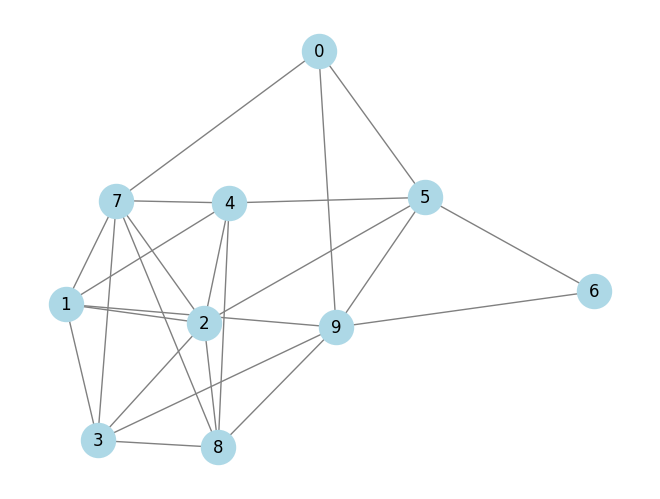

In [38]:
G = random_graph(10, 0.5)
draw_graph(G)
print(evaluate_graph(G))

# Dataset Generation

In [39]:
def generate_dataset(N, seed=None):
    if seed is not None:
        random.seed(seed)

    dataset = []
    for _ in range(N):
        n = random.randint(1, 20)
        p = random.uniform(0, 1)
        G = random_graph(n, p)
        results = evaluate_graph(G)
        dataset.append((G, results))
    return dataset

# generate a small dataset for output preview
sample_dataset = generate_dataset(3)
sample_dataset

[(graph with 6 vertices and 4 edges,
  {'max_degree': 2,
   'is_connected': False,
   'is_bipartite': True,
   'has_hamiltonian_cycle': False,
   'largest_clique_size': 2}),
 (graph with 2 vertices and 1 edges,
  {'max_degree': 1,
   'is_connected': True,
   'is_bipartite': True,
   'has_hamiltonian_cycle': True,
   'largest_clique_size': 2}),
 (graph with 13 vertices and 22 edges,
  {'max_degree': 6,
   'is_connected': True,
   'is_bipartite': False,
   'has_hamiltonian_cycle': False,
   'largest_clique_size': 4})]

In [40]:
def generate_prompt(G):
    edge_list_str = "\n".join(f"({u}, {v})" for u, v in G.E())
    prompt = f"""You are given an undirected graph with {len(G.V())} vertices labeled 0 through {len(G.V()) - 1}.

The edges of the graph are listed below. Each edge is represented as a pair of vertex labels (u, v), meaning there is an edge between vertex u and vertex v.

Edge List:
{edge_list_str}

Answer the following questions about the graph. Do not write code to compute any answers.

1. What is the maximum degree of any vertex in this graph? Output a single integer.
2. Is the graph connected? Output True or False.
3. Is the graph bipartite? Output True or False.
4. Does the graph contain a Hamiltonian cycle? Output True or False.
5. What is the size of the largest complete subgraph (clique) in this graph? Output a single integer.

Provide your answers in order, one per line, with no extra text."""
    return prompt

def save_dataset_to_csv(dataset, filename="graph_dataset.csv"):
    fieldnames = [
        "graph_id", "prompt",
        "true_max_degree", "true_connected", "true_bipartite", "true_hamiltonian_cycle", "true_clique_size",
        "llm_max_degree", "llm_connected", "llm_bipartite", "llm_hamiltonian_cycle", "llm_clique_size"
    ]

    rows = []
    for i, (G, eval_result) in enumerate(dataset):
        prompt = generate_prompt(G)
        row = {
            "graph_id": i,
            "prompt": prompt,
            "true_max_degree": eval_result["max_degree"],
            "true_connected": eval_result["is_connected"],
            "true_bipartite": eval_result["is_bipartite"],
            "true_hamiltonian_cycle": eval_result["has_hamiltonian_cycle"],
            "true_clique_size": eval_result["largest_clique_size"],
            "llm_max_degree": "",
            "llm_connected": "",
            "llm_bipartite": "",
            "llm_hamiltonian_cycle": "",
            "llm_clique_size": ""
        }
        rows.append(row)

    with open(filename, mode='w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(rows)

In [41]:
def save_graphs_to_json(dataset, filename="graph_data.json"):
    graph_dict = {}
    for i, (G, _) in enumerate(dataset):
        edge_list = list(map(list, G.E()))  # convert tuples to lists for JSON
        graph_dict[i] = {
            "num_vertices": len(G.V()),
            "edges": edge_list
        }

    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(graph_dict, f, indent=2)

In [43]:
# run this only once (already done)

full_dataset = generate_dataset(100)
save_dataset_to_csv(full_dataset, "graph_benchmark_dataset.csv")
save_graphs_to_json(full_dataset, "graph_data.json")